## Training

euclidean method: Total distance = 887.9557996584006, Visited cities = [8, 2, 11, 6, 3, 19, 35, 71, 39, 91, 25, 1, 26, 38, 64, 81, 85, 99, 75, 89, 29, 77, 16, 78, 36, 4, 48, 24, 92, 12, 30, 10, 21, 57, 84, 17, 60, 72, 15, 9, 62, 59, 43, 0, 56, 14, 5, 28, 27, 83, 41, 42, 76, 50, 54, 73, 93, 66, 18, 65, 32, 79, 63, 37, 70, 34, 55, 47, 95, 86, 23, 98, 67, 90, 13, 88, 87, 7, 68, 20, 94, 58, 61, 22, 82, 80, 49, 53, 44, 69, 46, 31, 45, 51, 96, 52, 97, 40, 74, 33]
cityblock method: Total distance = 1177.0, Visited cities = [22, 43, 84, 63, 17, 59, 50, 64, 56, 14, 47, 19, 39, 81, 37, 93, 52, 12, 40, 46, 8, 23, 86, 48, 31, 20, 44, 34, 90, 87, 29, 97, 36, 6, 94, 71, 80, 78, 85, 60, 28, 92, 16, 21, 3, 79, 4, 33, 45, 77, 10, 51, 69, 42, 68, 53, 54, 88, 11, 27, 67, 76, 75, 91, 57, 32, 41, 62, 66, 13, 89, 25, 95, 70, 99, 9, 82, 26, 65, 98, 58, 0, 96, 1, 15, 73, 49, 61, 38, 7, 72, 74, 2, 5, 24, 83, 18, 55, 35, 30]


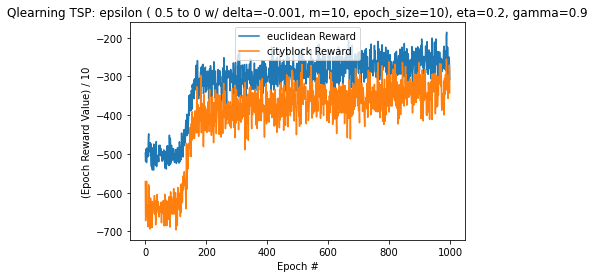

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

MAP_SIZE = 100
N_CITIES = 100
N_EPOCHS = 1000
EPOCH_SIZE = 10         # how many games to play per training epoch
METHODS = ["euclidean", "cityblock"]
INIT_EPSILON = 0.5      # probability of choosing a random action
EPSILON_MIN =  0        # when to stop decreasing epsilon by delta
E_DELTA = 0.001         # how much to change epsilon by ever M epochs
M = 10                  # number of epochs to pass before decreasing epsilon
ETA = 0.2               # learning rate
GAMMA = 0.9             # discount factor

def generate_city_coords(env_data):
  """
  generate N_CITIES cities with coordinates being integer values
  representing the horizontal and vertical cells within the map grid
  with height and width equal to MAP_SIZE
  """
  c = np.random.randint(100, size=(N_CITIES, 2))
  env_data["x_coords"] = c[:,0]
  env_data["y_coords"] = c[:,1]

def generate_q_vals(env_data):
  """
  populates env["q_cities"] with q values for the cities based on the method
  or heuristic in use
  assumes valid method that is present in METHODS is provided
  the method will be provided directly to cdist, so it must also be a valid
  parameter for that function.
  methods such as euclidean and manhattan (cityblock) distance work
  """
  # given x and y coords lists, column_stack generates a list of lists
  # of the [[x,y],..] coordinate pairs
  c = np.column_stack([env_data["x_coords"], env_data["y_coords"]])
  env_data["q_cities"] = cdist(c, c, env_data["method"])

def reset_cities(env_data):
  """
  replaces env_data["cities"] with an empty list, appends a random city id to it
  and retuns it
  """
  env_data["cities"] = []
  first_city_id = np.random.randint(N_CITIES)  # pick a random city for start
  env_data["cities"].append(first_city_id)
  return first_city_id

def get_action(agent_data, start_city):
  """
  either picks the best city out of the q-vector for that starting city
  or picks a random city from the non-visited ones
  and returns that city index as the action
  """
  q_vector = np.copy(agent_data["qmatrix"][start_city,:])
  visited = agent_data["states"]
  q_vector[visited] = -np.inf  # don't visit already visted cities
  if np.random.rand() > agent_data["epsilon"]:
    action = np.argmax(q_vector)  # best action index with highest q value
  else:  # otherwise, choose random non-visited action
    action = np.random.choice([x for x in range(q_vector.size) if x not in visited])
  return action

def do_action(env_data, next_city):
  """
  gets the current city
  appends the provided next city to the list of cities (state) in this env
  gets the reward value for the trip between the current city and the next one
  returns the reward
  """
  cur_city = env_data["cities"][-1]  # last city appended
  env_data["cities"].append(next_city) # append new_city to cities visited
  r = env_data["q_cities"][cur_city, next_city]
  return r

def train(agent_data, state, action, reward):
  """
  trains an agent with agent data:
  updates q matrix of the agent with newly calculated value for that
  state,action pair based on the formula for q learning
  next_state is action because we have encoded actions as the list of city
  indexes
  """
  next_state = action
  agent_data["qmatrix"][state, action] = \
    agent_data["qmatrix"][state, action] + ETA * (reward + \
      GAMMA * np.max(agent_data["qmatrix"][next_state, action]) - \
      agent_data["qmatrix"][state, action])

def run_training_epoch(env_data, agent_data):
  i = 0
  epoch_r = 0
  done = False
  start_city = reset_cities(env_data)
  agent_data["states"] = []
  while i < env_data["n_cities"] and not done:
    agent_data["states"].append(start_city)
    action = get_action(agent_data, start_city)  # next city to visit
    r = do_action(env_data, action)  # expected reward for doing so
    done = len(env_data["cities"]) == env_data["n_cities"]
    r = -1 * r
    train(agent_data, start_city, action, r)
    epoch_r += r
    start_city = action
    i += 1
  return epoch_r

def run_n_epochs(env_data, agent_data, n_epochs=1000):
  """
  runs n_epochs training epochs for agent with provided agent and environment
  data
  returns the modified environment, agent and a list of the rewards for
  the entire training period
  """
  rewards = []
  for i in range(n_epochs):
    rewards.append(run_training_epoch(env_data, agent_data))
    if i > 0 and i % M == 0:  # decrease epsilon by delta every M epochs
      agent_data["epsilon"] -= E_DELTA
  return rewards
  

def test_agent(env_data, agent_data):
  start_city = np.random.randint(env_data["n_cities"])
  visited_cities = [start_city]
  total_distance = 0
  for _ in range(env_data["n_cities"] - 1):
    current_city = visited_cities[-1]
    q_values = agent_data["qmatrix"][current_city, :]
    q_values[visited_cities] = -np.inf  # ignore visited cities

    next_city = np.argmax(q_values)

    visited_cities.append(next_city)

    total_distance += env_data["q_cities"][current_city, next_city]

  return total_distance, visited_cities


def plot_stats(rewards):
  """
  plots both rewards for each iteration of both methods
  """
  columns = ['Epoch']
  stats = []
  columns.append(METHODS[0])
  columns.append(METHODS[1])
  i = 0
  for r in rewards[METHODS[0]]:
    stats.append([
      i,
      rewards[METHODS[0]][i]/EPOCH_SIZE,
      rewards[METHODS[1]][i]/EPOCH_SIZE])
    i += 1
  df = pd.DataFrame(stats, columns=columns)
  plt.title("Qlearning TSP: " +
            "epsilon ( {} to 0 w/ delta=-{}, m={}, epoch_size={}), ".format(
            INIT_EPSILON, E_DELTA, M, EPOCH_SIZE) + "eta={}, gamma={}".format(
            ETA, GAMMA))
  plt.xlabel("Epoch #")
  plt.ylabel("(Epoch Reward Value) / {}".format(EPOCH_SIZE))
  plt.plot(df["Epoch"], df[METHODS[0]], label='{} Reward'.format(METHODS[0]))
  plt.plot(df["Epoch"], df[METHODS[1]], label='{} Reward'.format(METHODS[1]))
  plt.legend(loc='upper center')
  plt.show()

def main():
  """
  entry point of program
  runs qlearning training with two different methods, records the rewards
  per epoch for each method and graphs them for comparison
  """
  rewards = {}
  for method in METHODS:
    env_data = {
      "n_cities" : N_CITIES,
      "method" : method,
      "x_coords" : [],
      "y_coords" : [],
      "q_cities" : [],
      "cities" : [],
    }
    tsp_qagent_data = {
     "states_size" : N_CITIES,
     "actions_size" : N_CITIES,
     "epsilon" : INIT_EPSILON,
     "qmatrix" : np.zeros([N_CITIES, N_CITIES]),
     "states" : []
    }
    generate_city_coords(env_data)
    generate_q_vals(env_data)
    reset_cities(env_data)
    rewards[method] = run_n_epochs(env_data, tsp_qagent_data, N_EPOCHS)
    
    total_distance, visited_cities = test_agent(env_data, tsp_qagent_data)
    print(f"{method} method: Total distance = {total_distance}, Visited cities = {visited_cities}")
  plot_stats(rewards)


if __name__ == "__main__":
  main()